# 版本更新说明（2020.07.17）
- 增加关于预测图数据来源的详细说明
- 增加关于饱和预测的说明
- 增加统计数据开始时间处理
- 增加数据平滑与逆运算处理和说明
- 增加关于Prophet非常详细的参考资料链接：[时间序列模型Prophet使用详细讲解](https://blog.csdn.net/anshuai_aw1/article/details/83412058)


# 比赛介绍
[2020国际大数据竞赛：高致病性传染病的传播趋势预测](https://aistudio.baidu.com/aistudio/competition/detail/36)
![file](https://ai-studio-static-online.cdn.bcebos.com/1d785cb1cee14072aa1f2cd6d2703cc748e5903ff55243c6809bc046b18fbe0f)

## 赛题背景

传染病(Contagious Diseases)的有效防治是全人类面临的共同挑战,如何通过大数据,特别是数据的时空关联特性,来精准预测传染病的传播趋势和速度,将极大有助于人类社会控制传染病,保障社会公共卫生安全。希望借助此次竞赛,充分发挥全球选手的聪明才智,运用大数据技术助力传染病的传播预测和控制,增强人类社会合作抗风险的意识和能力 。

## 任务描述 
针对赛题所构造的若干虚拟城市，构造传染病群体传播预测模型，根据该地区传染病的历史每日新增感染人数、城市间迁徙指数、网格人流量指数、网格联系强度和天气等数据，预测群体未来一段时间每日新增感染人数。

## 数据集 
初赛阶段
训练数据（train_data）

训练集共包括5个城市，每个城市目录下的数据集总体说明：
1. 各区域每天新增感染人数。文件名：infection.csv。提供前45天每天数据，文件格式为城市ID,区域ID,日期,新增感染人数；“,”分割。
2. 城市间迁徙指数。文件名：migration.csv。提供45天每天数据。文件格式为迁徙日期,迁徙出发城市,迁徙到达城市,迁徙指数；“,”分割。
3. 网格人流量指数。文件名：density.csv。提供45天内每周两天抽样数据，文件格式为日期，小时，网格中心点经度,网格中心点纬度,人流量指数；“,”分割。
4. 网格关联强度。文件名：transfer.csv。城市内网格间关联强度数据，文件格式为小时，出发网格中心点经度，出发网格中心点纬度，到达网格中心点经度，到达网格中心点纬度，迁移强度；“,”分割。
5. 网格归属区域。文件名：grid_attr.csv。城市内网格对应的归属区域ID，文件格式为网格中心点经度，网格中心点纬度，归属区域ID；“,”分割。
6. 天气数据。文件名：weather.csv。提供45天每天数据，文件格式为日期,小时,气温,湿度,风向,风速,风力,天气；“,”分割。

## 官方baseline
[基于飞桨PGL的高致病性传染病的传播趋势预测基线系统](https://aistudio.baidu.com/aistudio/projectdetail/457185)

# Prophet 简介
Prophet是Facebook开源的时间序列预测算法，可以有效处理节假日信息，并按周、月、年对时间序列数据的变化趋势进行拟合。根据官网介绍，Prophet对具有强烈周期性特征的历史数据拟合效果很好，不仅可以处理时间序列存在一些异常值的情况，也可以处理部分缺失值的情形。算法提供了基于Python和R的两种实现方式。
> 从论文上的描述来看，这个 prophet 算法是基于时间序列分解和机器学习的拟合来做的，其中在拟合模型的时候使用了 pyStan 这个开源工具，因此能够在较快的时间内得到需要预测的结果。

## 参考资料
- [时间序列模型Prophet使用详细讲解](https://blog.csdn.net/anshuai_aw1/article/details/83412058)
- [Prophet官网](https://facebook.github.io/prophet/)
- [github项目](https://github.com/facebook/prophet)
- [论文：Forecasting at scale](https://link.zhihu.com/?target=https%3A//peerj.com/preprints/3190/)
- [Facebook 时间序列预测算法 Prophet 的研究](https://zhuanlan.zhihu.com/p/52330017)

## 安装依赖库
从安装的依赖库看，Prophet依赖的日历库非常丰富，包括了各国使用的多种历法，如农历等。

In [1]:
!pip3 install pystan
!pip3 install fbprophet
!pip3 install -U pandas

# Prophet入门
- Prophet遵循sklearn模型API的用法。
- Prophet的输入只有两列：时间`ds`和度量值`y`。
	- `ds`最好是`YYYY-MM-DD`的日期格式或者`YYYY-MM-DD HH:MM:SS`的时间戳格式。
    - `y`必须是数值。

In [2]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
# 忽略版本问题
import warnings
warnings.filterwarnings("ignore")  

## 准备数据集

In [3]:
# 数据集解压缩
# !unzip data/data33637/train_data.zip

In [4]:
# 使用Prophet只需要用到infection.csv，导入数据时直接将日期列和感染人数字段改名为ds和y，简化后续步骤
df_A = pd.read_csv('train_data/city_A/infection.csv', names=['city_id', 'region_id' ,'ds', 'y'], parse_dates=['ds'])
df_A.head()

,city_id,region_id,ds,y
0,A,0,2120-05-01,0
1,A,0,2120-05-02,0
2,A,0,2120-05-03,0
3,A,0,2120-05-04,0
4,A,0,2120-05-05,0


## 计算某区域的感染人数趋势

In [5]:
df_A0 = df_A[df_A.region_id==0]
# 删除与时序预测不相关的列
df_A0.drop(columns=['city_id', 'region_id'], inplace=True)

In [6]:
# 时间是连续的，因此不需要做额外处理
df_A0

,ds,y
0,2120-05-01,0
1,2120-05-02,0
2,2120-05-03,0
3,2120-05-04,0
4,2120-05-05,0
5,2120-05-06,0
6,2120-05-07,0
7,2120-05-08,0
8,2120-05-09,0
9,2120-05-10,0


In [7]:
# 查看该区域疫情最早发生时间
df_A0[df_A0.index >= (df_A0.y>0).idxmax()]

,ds,y
25,2120-05-26,1
26,2120-05-27,19
27,2120-05-28,33
28,2120-05-29,41
29,2120-05-30,59
30,2120-05-31,63
31,2120-06-01,163
32,2120-06-02,420
33,2120-06-03,165
34,2120-06-04,189


## 拟合感染数据
通过对一个Prophet对象进行实例化来拟合模型，**任何影响预测过程的设置都将在构造模型时被指定**。接下来，就可以使用fit方法代入历史数据集来拟合模型，拟合过程一般非常短。

In [8]:
# 是否从当地出现感染人员后开始预测
# df_A0 = df_A0[df_A0.index >= (df_A0.y>0).idxmax()]
# 考虑到感染清零后的情况，本文的时间截取到当地出现疫情前三天
df_A0 = df_A0[df_A0.index >= (df_A0.y>0).idxmax()-3]

In [9]:
# Python
m = Prophet()
m.fit(df_A0)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


## 预测传播趋势
预测过程则需要建立在包含日期ds列的数据框基础上。通过使用Prophet.make_future_dataframe来将未来的日期扩展指定的天数，得到一个合规的数据框。**默认情况下，这样做会自动包含历史数据的日期，因此我们也可以用来查看模型对于历史数据的拟合效果**。

In [10]:
# 可以指定预测天数
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
48,2120-07-10
49,2120-07-11
50,2120-07-12
51,2120-07-13
52,2120-07-14


predict方法将会对每一行未来future日期得到一个预测值（称为`yhat`）。如果你传入了历史数据的日期，它将会提供样本的模型拟合值。预测forecast创建的对象应当是一个新的数据框，**其中包含一列预测值`yhat ，以及成分的分析和置信区间。**

In [11]:
# 不仅可以预测准确的数值，还可以生成预测的上下限
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
48,2120-07-10,142.230466,38.022374,251.554583
49,2120-07-11,109.248006,0.160351,208.062427
50,2120-07-12,118.274881,14.182598,228.760197
51,2120-07-13,159.469763,51.386943,265.190843
52,2120-07-14,236.567799,134.196011,343.617214


## 绘制预测图
这里用到了Prophet.plot画图函数

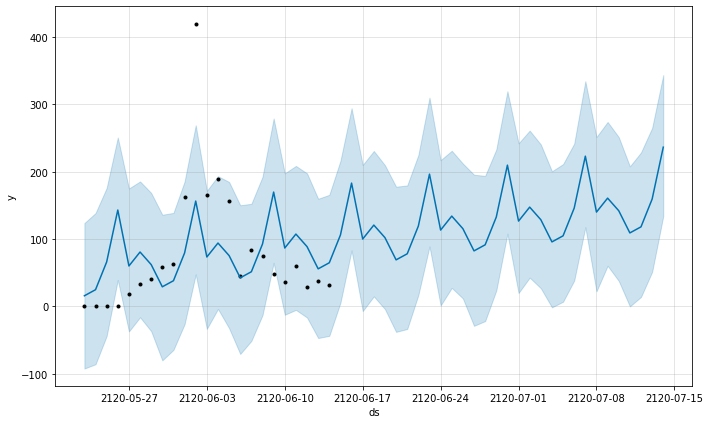

In [12]:
# Python
fig1 = m.plot(forecast)

如果想看到组合预测结果，可以用Prophet.plot_components。默认可以看按年、按周、按月的时间序列趋势。如果引入节假日数据，这里也能看到。

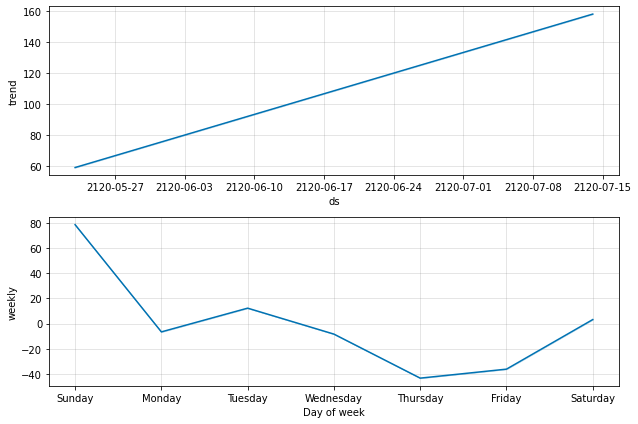

In [13]:
# Python
fig2 = m.plot_components(forecast)

### 理解预测图

In [14]:
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


In [15]:
forecast[['trend','yhat','weekly','additive_terms']].tail()

,trend,yhat,weekly,additive_terms
48,150.503750,142.230466,-8.273284,-8.273284
49,152.408474,109.248006,-43.160468,-43.160468
50,154.313199,118.274881,-36.038318,-36.038318
51,156.217924,159.469763,3.251839,3.251839
52,158.122649,236.567799,78.445150,78.445150


- fig2的整体趋势图源于`forecast['trend']`，按周的序列趋势源于`forecast['weekly']`
- 因为是加法模型，并且没有年趋势，因此：
	- forecast['additive_terms'] = forecast['weekly']
	- forecast['yhat']  = forecast['trend'] + forecast['additive_terms']
	- forecast['yhat']  = forecast['trend'] +forecast['weekly']

# Prophet进阶

## 绘制上下限
- 上限
	- 假设我们认为，传染病的传播趋势会随着预防措施的深入而有所控制，也就说二次高峰不会更高，那么预测趋势就有了上限
- 下限
	- 预测下限自然是0
 
其原理来自于Proohet的饱和预测概念：
> 默认情况下，Prophet使用线性模型进行预测。当预测增长情况时，通常会存在可到达的最大极限值，例如：总市场规模、总人口数等等。这被称做承载能力（carrying capacity），那么预测时就应当在接近该值时趋于饱和。Prophet可使用logistic增长趋势模型进行预测，同时指定承载能力。**该值的设置通常情况下应当通过专业知识来决定，但是不一定必须是恒定值，其本身也可以随时间序列变化。**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


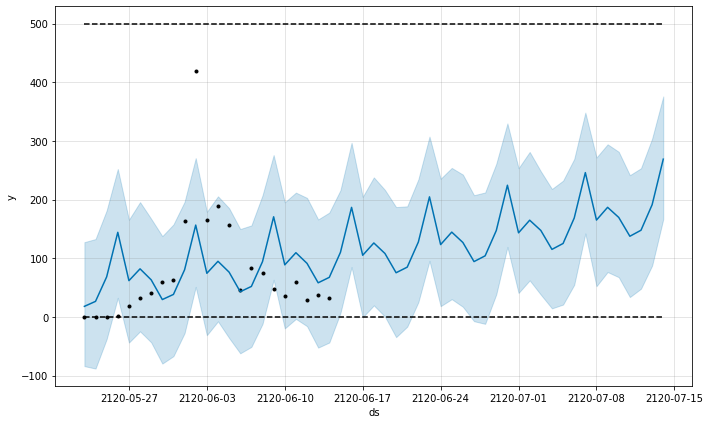

In [16]:
# 上限，这里姑且认为可以是一个固定值
df_A0['cap'] = 500
# 
df_A0['floor'] = 0
future['cap'] = 500
future['floor'] = 0
m = Prophet(growth='logistic')
m.fit(df_A0)
fcst = m.predict(future)
fig = m.plot(fcst)

## 数据平滑和数据开始时间处理
Prophet官方文档的示例数据中，对要预测的数值列做过了log处理（即，做过`df['y'] = np.log(df['y'])`操作）

对于时间序列预测，这种数据平滑的做法还是非常有效的，尤其是在接近指数增长的场景上，大幅降低上线设置的难度。

但是log处理在0值上会遇到问题，下面提供两种解决思路，最终选择的做法参考了：
[数据平滑处理——np.log1p() and np.exmp1()](https://www.cnblogs.com/cassielcode/p/12486381.html)

同时，我们也应该考虑到，由于各城市最初感染人数都是0，这种情况会影响到Prophet的拟合效果，***可能***可以考虑从开始出现感染的那天开始拟合。

### 方法一：单独定义0值点的处理

In [17]:
def trick_log(x):
    if x == 0:
        x = 0
    else :
        x = np.log(x)
    return x

### 方法二：使用log1p与其逆运算expm1（本项目使用该方法）
$log1p = log(x+1)$

$expm1 = exp(x)-1$

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


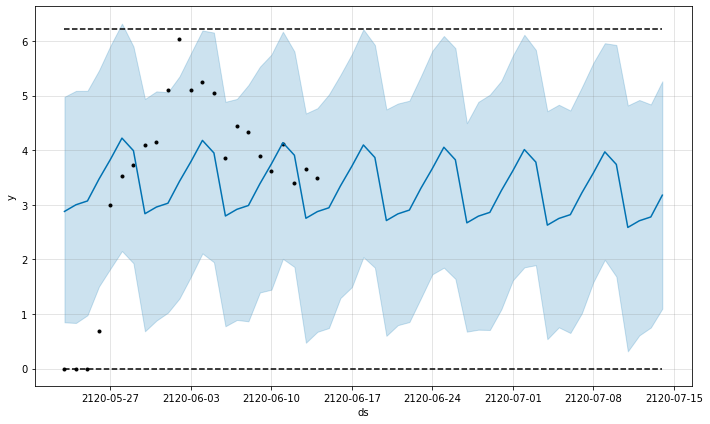

In [18]:
df_A0['y'] =  df_A0['y'].apply(lambda x:np.log1p(x))
# 上限，这里姑且认为可以是一个固定值
df_A0['cap'] = np.log1p(500)
df_A0['floor'] = 0
future['cap'] = np.log1p(500)
future['floor'] = 0
m = Prophet(growth='logistic')
m.fit(df_A0)
fcst = m.predict(future)
fig = m.plot(fcst)

## 变化点监控
Prophet可以对数据集中潜在的趋势变化点进行检测然后绘制变化趋势。默认会在前80%的数据里找25个潜在变化点。

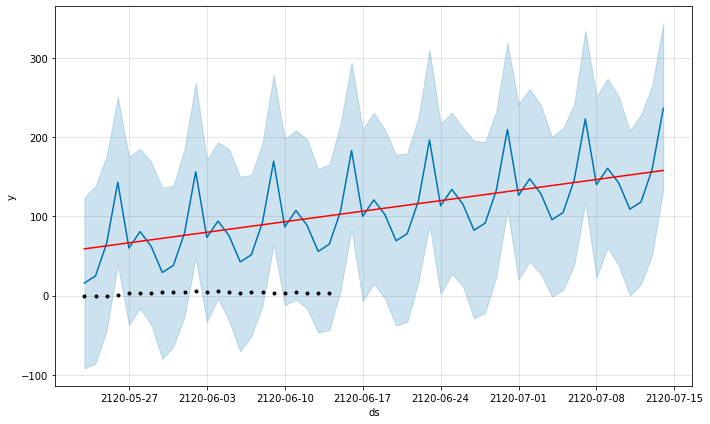

In [19]:
# Python
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### 调整变化幅度

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


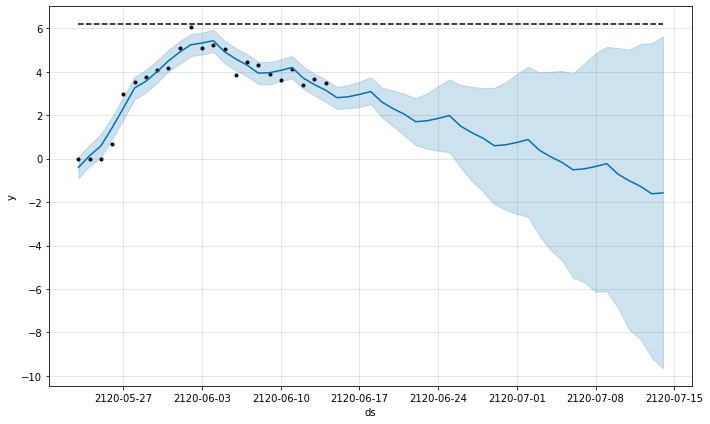

In [20]:
# 变化幅度较大
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(df_A0).predict(future)
fig = m.plot(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


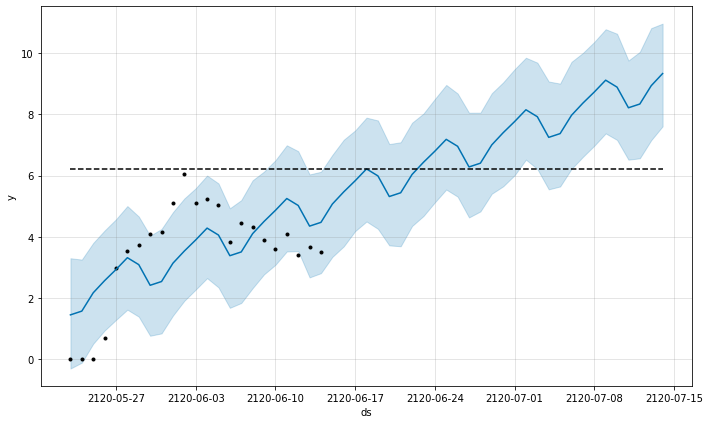

In [21]:
# 变化幅度较小
m = Prophet(changepoint_prior_scale=0.01)
forecast = m.fit(df_A0).predict(future)
fig = m.plot(forecast)

### 自定义变化点
如果自定义变化点选择不当，对历史数据趋势变化将出现非常明显的过拟合现象。

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


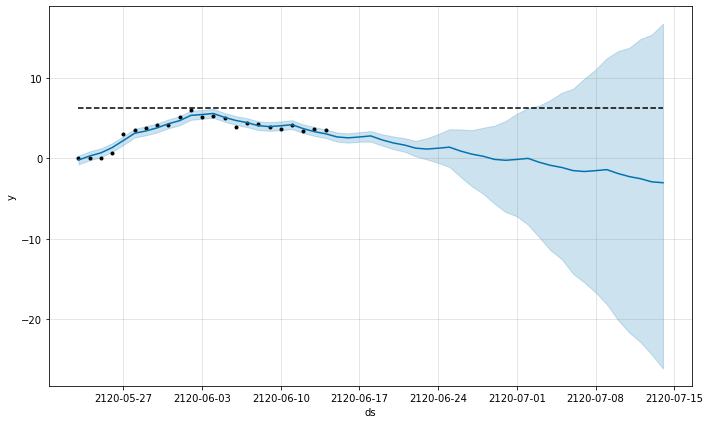

In [22]:
m = Prophet(changepoint_prior_scale=0.5, changepoints=['2120-06-02'])
forecast = m.fit(df_A0).predict(future)
fig = m.plot(forecast)

## 定义重大时间点
这里指的是特殊节假日或者所在地区颁布防疫措施的时间点等，会对传染趋势造成影响的关键节点，具体可能需要从另外几个文件中分析得到。

In [23]:
starter = pd.DataFrame({
  'holiday': 'starter',
  'ds': pd.to_datetime(['2120-05-26']),
  'lower_window': 0,
  'upper_window': 10,
})
lockdown = pd.DataFrame({
  'holiday': 'lockdown',
  'ds': pd.to_datetime(['2120-06-02']),
  'lower_window': 0,
  'upper_window': 30,
})
holidays = pd.concat((starter, lockdown))

In [24]:
# 上限
df_A0['cap'] = np.log1p(500)
# 
df_A0['floor'] = 0
future['cap'] = np.log1p(200)
future['floor'] = 0
m = Prophet(holidays=holidays)
forecast = m.fit(df_A0).predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


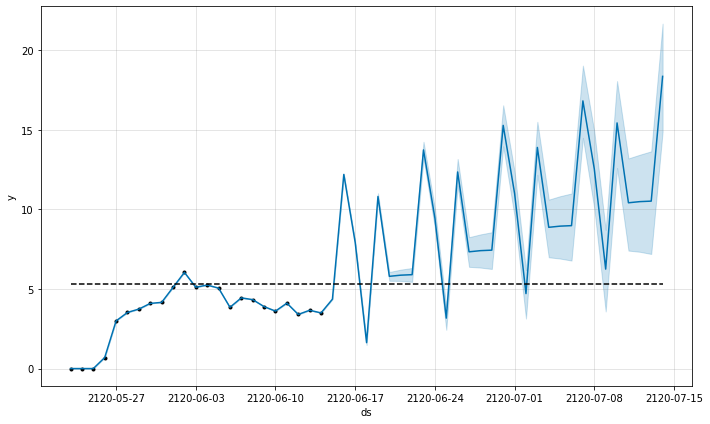

In [25]:
# 传播趋势预测
fig1 = m.plot(forecast)

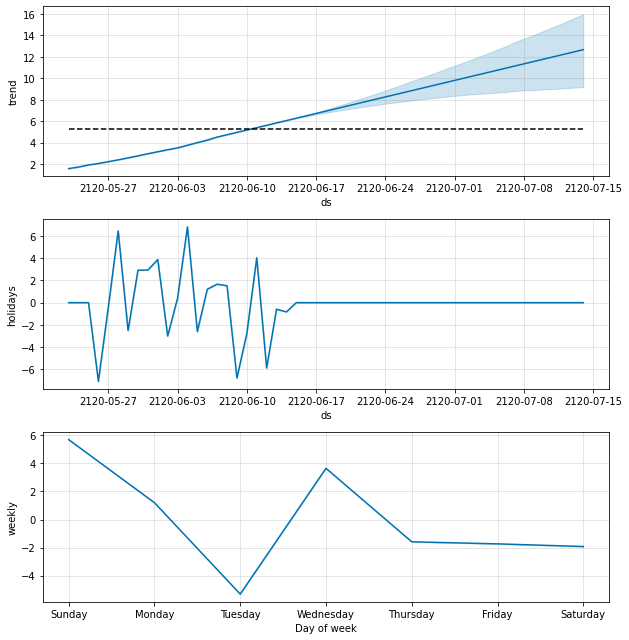

In [26]:
# Python
fig = m.plot_components(forecast)

In [27]:
# 因为设置了holidays，我们会发现预测结果中出现了源于forecast['holidays']和forecast['lockkdown']的预测图
print(forecast.columns)

Index(['ds', 'trend', 'cap', 'yhat_lower', 'yhat_upper', 'trend_lower',
       'trend_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'holidays', 'holidays_lower', 'holidays_upper',
       'lockdown', 'lockdown_lower', 'lockdown_upper', 'starter',
       'starter_lower', 'starter_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


In [28]:
# holidays的影响会出现在加法模型中，如果预测的时间点受holidays影响，forecast['yhat']会体现这个结果
forecast[['trend','yhat','weekly','lockdown','holidays','additive_terms']].head()

,trend,yhat,weekly,lockdown,holidays,additive_terms
0,1.585794,8.903989e-14,-1.585794,0.0,0.000000,-1.585794
1,1.732874,-4.489742e-13,-1.732874,0.0,0.000000,-1.732874
2,1.921595,1.381117e-13,-1.921595,0.0,0.000000,-1.921595
3,2.060699,6.931472e-01,5.698228,0.0,-7.065779,-1.367551
4,2.228531,2.995732e+00,1.202137,0.0,-0.434936,0.767201


## 指定国家节假日
由于数据集是虚拟城市虚拟时间，因此虽然Prophet可以指定法定节假日，但是在该数据集中没什么意义

In [29]:
# m = Prophet(holidays=holidays)
# m.add_country_holidays(country_name='US')
# m.fit(df_A0)

In [30]:
# m.train_holiday_names

In [31]:
# forecast = m.predict(future)
# fig = m.plot_components(forecast)

## 生成预测结果
选取拟合情况看起来比较好的参数设置开始预测

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


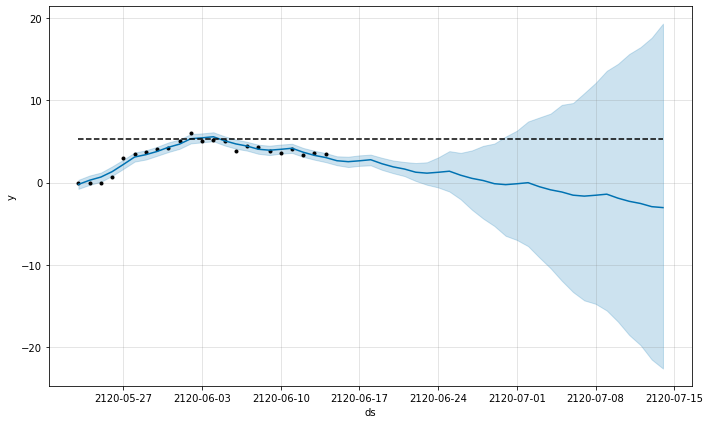

In [32]:
m = Prophet(changepoint_prior_scale=0.5, changepoints=['2120-06-02'])
forecast = m.fit(df_A0).predict(future)
fig = m.plot(forecast)

In [33]:
forecast[['trend','yhat','weekly','additive_terms']].tail()

,trend,yhat,weekly,additive_terms
48,-2.026305,-1.888063,0.138243,0.138243
49,-2.225791,-2.270229,-0.044438,-0.044438
50,-2.425277,-2.533572,-0.108295,-0.108295
51,-2.624763,-2.919831,-0.295068,-0.295068
52,-2.824249,-3.035286,-0.211037,-0.211037


In [34]:
output = forecast.tail(30)
output = output[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
output.columns = ['预测日期', '预测值', '预测下限', '预测上限']

### 预测结果处理
- 负值预测处理
- 数据平滑逆运算处理

In [35]:
def floor(x):
    if x < 0:
        x=0
    return x
output['预测值'] = output['预测值'] .apply(lambda x:np.expm1(x))
output['预测下限'] = output['预测下限'] .apply(lambda x:np.expm1(x))
output['预测下限'] = output['预测下限'] .apply(lambda x:np.expm1(x))
output['预测值'] = output['预测值'] .apply(lambda x:floor(x))
output['预测下限'] = output['预测下限'] .apply(lambda x:floor(x))

In [36]:
output.head()

,预测日期,预测值,预测下限,预测上限
23,2120-06-15,13.379093,1506.507644,3.202907
24,2120-06-16,11.811207,284.373054,3.154178
25,2120-06-17,13.250195,834.804198,3.317924
26,2120-06-18,15.249815,1343.781866,3.406751
27,2120-06-19,8.985579,41.262773,3.020479


# 城市流量分析
对城市整体流量进行分析，寻找影响传染病传播趋势的重大时间点

## A城市

In [37]:
df_Ap = pd.read_csv('train_data/city_A/density.csv', names=['date', 'hour', 'longitude',
'latitude' , 'population'], parse_dates=['date'])

从重点地区的平均人流量可以看出，A城市在2120-05-31-2120-06-02前后的确可能采取了防疫措施，是传染病传播趋势变化的重要时间点。

In [38]:
df_Ap.groupby('date').agg({'population':'mean'})

,population
date,
2120-05-06,5.886265
2120-05-09,5.944506
2120-05-13,6.086248
2120-05-16,6.182464
2120-05-20,5.879494
2120-05-23,6.076208
2120-05-27,6.160414
2120-05-30,5.857858
2120-06-03,2.463644


## B城市
从分析结果看，B城市基本没有采取任何防疫措施

In [39]:
df_Bp = pd.read_csv('train_data/city_B/density.csv', names=['date', 'hour', 'longitude',
'latitude' , 'population'], parse_dates=['date'])

In [40]:
df_Bp.groupby('date').agg({'population':'mean'})

,population
date,
2120-05-06,2.294827
2120-05-09,2.518198
2120-05-13,2.530414
2120-05-16,2.571256
2120-05-20,2.467567
2120-05-23,2.546843
2120-05-27,2.551593
2120-05-30,2.502612
2120-06-03,2.469615


## C城市
C城市看起来是个人流量很大却也是走“群体免疫”路线的

In [41]:
df_Cp = pd.read_csv('train_data/city_C/density.csv', names=['date', 'hour', 'longitude',
'latitude' , 'population'], parse_dates=['date'])
df_Cp.groupby('date').agg({'population':'mean'})

,population
date,
2120-05-06,5.368010
2120-05-09,5.679790
2120-05-13,5.692595
2120-05-16,5.740336
2120-05-20,5.520997
2120-05-23,5.689672
2120-05-27,5.713816
2120-05-30,5.581096
2120-06-03,5.553714


## D城市
同C城市，人流量大，疫情期间没有明显变化

In [42]:
df_Dp = pd.read_csv('train_data/city_D/density.csv', names=['date', 'hour', 'longitude',
'latitude' , 'population'], parse_dates=['date'])
df_Dp.groupby('date').agg({'population':'mean'})

,population
date,
2120-05-06,4.251946
2120-05-09,4.608541
2120-05-13,4.698850
2120-05-16,4.713357
2120-05-20,4.535413
2120-05-23,4.669777
2120-05-27,4.709533
2120-05-30,4.552833
2120-06-03,4.519542


## E城市
同B城市，人流量较小，也没有采取什么措施

In [43]:
df_Ep = pd.read_csv('train_data/city_E/density.csv', names=['date', 'hour', 'longitude',
'latitude' , 'population'], parse_dates=['date'])
df_Ep.groupby('date').agg({'population':'mean'})

,population
date,
2120-05-06,2.092576
2120-05-09,2.079618
2120-05-13,2.087031
2120-05-16,2.139687
2120-05-20,2.023780
2120-05-23,2.122559
2120-05-27,2.113604
2120-05-30,2.062732
2120-06-03,2.059434


# 模拟B、C、D、E城市未来也不采取措施的情况下，感染人数趋势预测

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


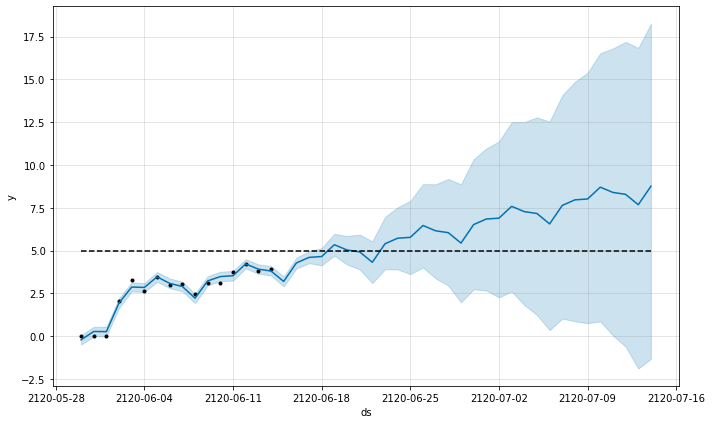

In [44]:
df_B = pd.read_csv('train_data/city_B/infection.csv', names=['city_id','region_id', 'ds', 'y'], parse_dates=['ds'])
df_B0 = df_B[df_B.region_id==0]
df_B0.drop(columns=['city_id', 'region_id'], inplace=True)
df_B0 = df_B0[df_B0.index >= (df_B0.y>0).idxmax()-3]
df_B0['y'] =  df_B0['y'].apply(lambda x:np.log1p(x))
# 上限，这里姑且认为可以是一个固定值
df_B0['cap'] = 5
df_B0['floor'] = 0
m = Prophet(growth='logistic')
m = Prophet(changepoint_prior_scale=0.5)
m.fit(df_B0)
future = m.make_future_dataframe(periods=30)
future['cap'] = 5
future['floor'] = 0
forecast = m.predict(future)
fig1 = m.plot(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


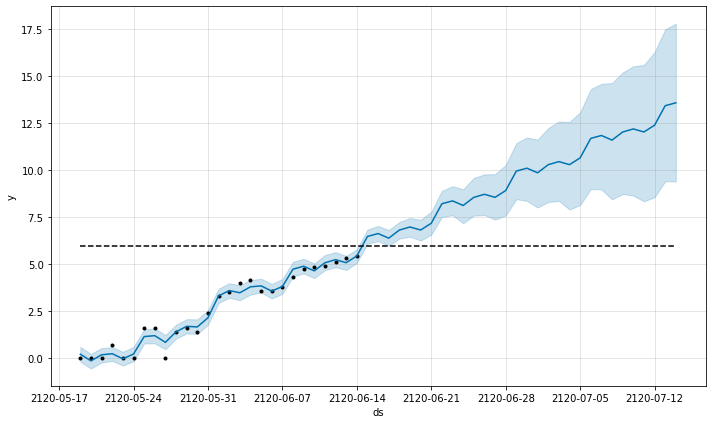

In [45]:
df_C = pd.read_csv('train_data/city_C/infection.csv', names=['city_id','region_id', 'ds', 'y'], parse_dates=['ds'])
df_C0 = df_C[df_C.region_id==0]
df_C0.drop(columns=['city_id', 'region_id'], inplace=True)
df_C0 = df_C0[df_C0.index >= (df_C0.y>0).idxmax()-3]
df_C0['y'] =  df_C0['y'].apply(lambda x:np.log1p(x))
# 上限，这里姑且认为可以是一个固定值
df_C0['cap'] = 6
df_C0['floor'] = 0
m = Prophet(changepoint_prior_scale=0.5)
m.fit(df_C0)
future = m.make_future_dataframe(periods=30)
future['cap'] = 6
future['floor'] = 0
forecast = m.predict(future)
fig1 = m.plot(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


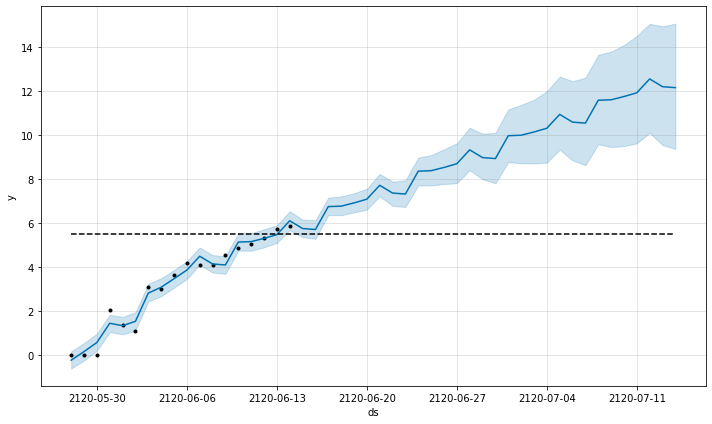

In [46]:
df_D = pd.read_csv('train_data/city_D/infection.csv', names=['city_id','region_id', 'ds', 'y'], parse_dates=['ds'])
df_D0 = df_D[df_D.region_id==0]
df_D0.drop(columns=['city_id', 'region_id'], inplace=True)
df_D0 = df_D0[df_D0.index >= (df_D0.y>0).idxmax()-3]
df_D0['y'] =  df_D0['y'].apply(lambda x:np.log1p(x))
# 上限，这里姑且认为可以是一个固定值
df_D0['cap'] = 5.5
df_D0['floor'] = 0
m = Prophet(changepoint_prior_scale=0.5)
m.fit(df_D0)
future = m.make_future_dataframe(periods=30)
future['cap'] = 5.5
future['floor'] = 0
forecast = m.predict(future)
fig1 = m.plot(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


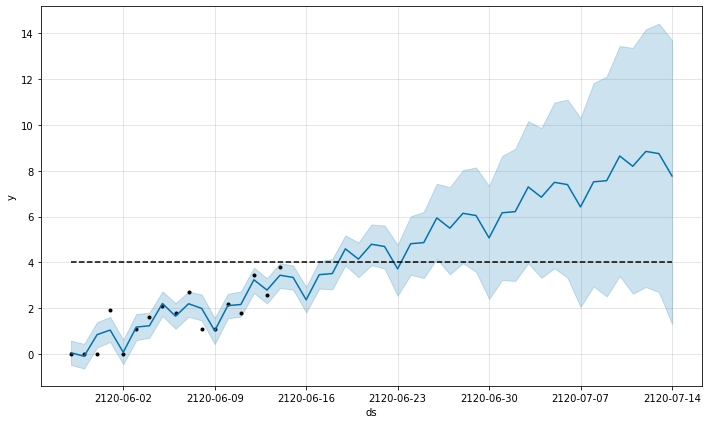

In [47]:
df_E = pd.read_csv('train_data/city_E/infection.csv', names=['city_id','region_id', 'ds', 'y'], parse_dates=['ds'])
df_E0 = df_E[df_E.region_id==0]
df_E0.drop(columns=['city_id', 'region_id'], inplace=True)
df_E0 = df_E0[df_E0.index >= (df_E0.y>0).idxmax()-3]
df_E0['y'] =  df_E0['y'].apply(lambda x:np.log1p(x))
# 上限，这里姑且认为可以是一个固定值
df_E0['cap'] = 4
df_E0['floor'] = 0
m = Prophet(changepoint_prior_scale=1)
m.fit(df_E0)
future = m.make_future_dataframe(periods=30)
future['cap'] = 4
future['floor'] = 0
forecast = m.predict(future)
fig1 = m.plot(forecast)

# 批量预测
- 该场景下Prophet最大的劣势就是批量预测，因为使用Prophet意味着我们需要将每个城市、每个区域的数据都提取出来做一个预测，然后把预测结果写到train_data/submission.csv文件中
- 并且，每个城市、每个区域的最佳拟合曲线参数都不一致，如果手动计算，工作量会非常大
- 这里先尝试使用批量预测脚本，做一个近似预测，当然，准确性比较差

In [48]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
import gc
from tqdm import tqdm

def floor(x):
    if x < 0:
        x=0
    return x


def prophet_batch(path, city, changepoint_prior_scale, changepoints,cap):
    df = pd.read_csv(path, names=['city_id','region_id', 'ds', 'y'], parse_dates=['ds'])
    result = pd.DataFrame()
    for i, element in enumerate(tqdm(df.region_id.unique())):
        df_ = df[df.region_id==element]
        df_.drop(columns=['city_id', 'region_id'], inplace=True)
        df_ = df_[df_.index >= (df_.y>0).idxmax()-3]
        # 数据平滑
        df_['y'] =  df_['y'].apply(lambda x:np.log1p(x))
        df_['cap'] = cap
        df_['floor'] = 0
        # print(df_)
        # 如果没有采取防疫措施
        if changepoints is None:
            m = Prophet(changepoint_prior_scale=changepoint_prior_scale)
            m.fit(df_)
            future = m.make_future_dataframe(periods=30)
            future['cap'] = cap
            forecast = m.predict(future)
            output = forecast.tail(30)
            # 取预测值
            output = output[['ds', 'yhat']]
            # 数据平滑逆运算
            output['y'] = output['yhat'].apply(lambda x:np.expm1(x))
            # 将负数转为0
            output['y'] = output['y'].apply(lambda x:floor(x))
            # 转换预测值为整数
            output['y'] = output['y'].astype(np.int32)
            output['city_id'] = city
            output['region_id'] = ''
            output['region_id'] = output['region_id'].apply(lambda x: element)
        # 采取防疫措施
        else:
            m = Prophet(changepoint_prior_scale=changepoint_prior_scale, changepoints=changepoints)
            m.fit(df_)
            future = m.make_future_dataframe(periods=30)
            future['cap'] = cap
            forecast = m.predict(future)
            output = forecast.tail(30)
            # 取标准预测值
            output = output[['ds', 'yhat']]
            # 数据平滑逆运算
            output['y'] = output['yhat'].apply(lambda x:np.expm1(x))
            # 将负数转为0
            output['y'] = output['y'].apply(lambda x:floor(x))
            # 转换预测值为整数
            output['y'] = output['y'].astype(np.int32)
            output['city_id'] = city
            output['region_id'] = ''
            output['region_id'] = output['region_id'].apply(lambda x: element)
        output = output[['city_id','region_id', 'ds', 'y']]
        # print(output.head())
        result = result.append(output)
    result.to_csv('train_data/result' + city + '.csv', index=False, header=None)

In [49]:
# prophet_batch('train_data/city_A/infection.csv', 'A', 0.5, ['2120-06-02'], 4)

In [50]:
# prophet_batch('train_data/city_B/infection.csv', 'B', 0.5, None, 4)

In [51]:
# prophet_batch('train_data/city_C/infection.csv', 'C', 0.5, None, 6)

In [52]:
# prophet_batch('train_data/city_D/infection.csv', 'D', 0.5, None, 5.5)

In [53]:
# prophet_batch('train_data/city_E/infection.csv', 'E', 1, None, 4)

# 小结
Prophet基线模型的算法仅比官方baseline有微小提升，主要有以下原因：
- 特征维度单一，仅有时间维度，无法用到训练数据集中的人员流动数据
- 由于仅有时间维度，并且只有45天的感染数据，Prophet在较长时间跨度上对节假日、重要时间点、周期性预测的优势无法体现
- 使用Prophet需要对数百个地区分别预测，如果使用批量预测，将进一步导致准确率偏低